## Pregunta: T2 - ¿Es normal que aumente el número de dependencias de un paquete respecto al tiempo? Correlación entre el número de versión y el número de dependencias

### 1. Importaciones

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import statsmodels.api as sm

from IPython.display import display, Markdown

### 2. Lectura

In [2]:
df = pd.read_csv("../../datawarehouse/processed-ubuntu-packages.csv")

### 3. Preprocesado

In [5]:
# Obtener unicamente Distro-Version, Package y Depends
df = df[["Distro-Version", "Package", "Depends"]]

# Convertimos Depends a lista
df['Depends'] = df['Depends'].apply(lambda x: str(x).split(','))

# Calculamos el número de dependencias de cada paquete y agregarlo como una nueva columna al dataframe
df['Num_Depends'] = df['Depends'].apply(lambda x: len(x))

df.head()

,Distro-Version,Package,Depends,Num_Depends
0,18.04 - bionic,acct,"[['libc6 (>= 2.14)', ' lsb-base']]",2
1,18.04 - bionic,acl,"[['libacl1 (= 2.2.52-3build1)', ' libc6 (>= 2...",2
2,18.04 - bionic,acpi-support,[['acpid (>= 1.0.4-1ubuntu4)']],1
3,18.04 - bionic,acpid,"[['libc6 (>= 2.15)', ' init-system-helpers (>...",4
4,18.04 - bionic,adduser,"[['passwd', ' debconf (>= 0.5) | debconf-2.0']]",2


### 4. Análisis

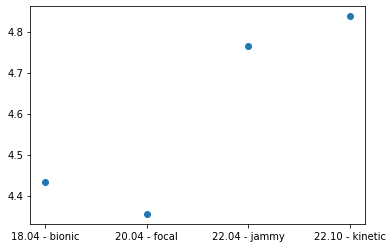

In [14]:
# Agrupamos los datos por versión y calculamos la media del número de dependencias para cada versión
grouped = df.groupby('Distro-Version')['Num_Depends'].mean()

plt.scatter(grouped.index, grouped.values)
plt.show()

Como podemos comprobar en la gráfica, el número de dependencias aumenta ligeramente pero sigue siendo un número entre 4 y 5. Comprobemos ahora la correlación entre las versiones y el número de dependencias.

In [16]:
# Importar pearsonr
from scipy.stats import pearsonr

# Asignar un número a cada versión
version_numbers = {}
for i, version in enumerate(grouped.index):
    version_numbers[version] = i
    
# Crear una nueva serie de valores numéricos para las versiones
version_values = [version_numbers[version] for version in grouped.index]

# Calcular la correlación entre la serie de valores numéricos de las versiones y la serie de valores numéricos del número de dependencias
stats.pearsonr(version_values, grouped.values)


(0.8767942989922227, 0.12320570100777728)

El resultado de la función stats.pearsonr() es una tupla que contiene dos valores: el coeficiente de correlación de Pearson y el valor p asociado.

El coeficiente de correlación de Pearson es un número entre -1 y 1 que indica la fuerza y la dirección de la relación lineal entre dos variables. En este caso, el valor de 0.8767942989922227 indica una correlación positiva fuerte entre el número de versión de la distribución y el número medio de dependencias.

El valor p asociado es la probabilidad de que se observe un coeficiente de correlación de Pearson igual o mayor que el observado si la verdadera correlación entre las dos variables es cero (es decir, si las dos variables no están relacionadas). En este caso, el valor de 0.12320570100777728 indica que no hay suficiente evidencia para rechazar la hipótesis nula de que la verdadera correlación entre las dos variables es cero. Esto significa que la correlación observada podría ser debida al azar y no necesariamente refleja una verdadera relación entre las dos variables.

### Análisis de varianza Anova

El test que se utiliza para comparar la media de múltiples grupos de datos es llamado análisis de varianza (ANOVA). En particular, el ANOVA unidireccional es el que se utiliza para comparar la media de varios grupos independientes.

En Python, la función scipy.stats.f_oneway() realiza un ANOVA unidireccional y devuelve el valor del estadístico F y el valor p asociado. Si el valor p es menor que el nivel de significancia predefinido, se rechaza la hipótesis nula de que todas las medias son iguales y se concluye que al menos una de las medias es diferente de las demás.

In [17]:
from scipy.stats import f_oneway

# Obtener los datos de cada grupo
data_bionic = df[df['Distro-Version'] == '18.04 - bionic']['Num_Depends']
data_focal = df[df['Distro-Version'] == '20.04 - focal']['Num_Depends']
data_jammy = df[df['Distro-Version'] == '22.04 - jammy']['Num_Depends']
data_kinetic = df[df['Distro-Version'] == '22.10 - kinetic']['Num_Depends']

# Realizar el test ANOVA
f_stat, p_value = f_oneway(data_bionic, data_focal, data_jammy, data_kinetic)

# Imprimir el resultado
print("F-statistic:", f_stat)
print("p-value:", p_value)


F-statistic: 119.11784473362188
p-value: 4.2396522968956445e-77


El F-statistic es bastante grande (119.11784473362188) y el p-value es extremadamente pequeño (4.2396522968956445e-77). Esto sugiere que hay una gran diferencia entre las medias de los grupos y que esta diferencia es muy poco probable que se deba al azar. Por lo tanto, se puede concluir que hay una diferencia significativa entre al menos dos de los grupos y se puede proceder a realizar pruebas post-hoc para determinar cuáles son los grupos que difieren significativamente.

### Prueba post-hoc de Tukey

La prueba post-hoc de Tukey es una prueba de comparación múltiple que se utiliza para determinar cuáles de los grupos son diferentes entre sí. En este caso, se utilizará para determinar cuáles de los grupos de distribuciones tienen una media diferente en el número de dependencias.

In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(grouped.values, grouped.index)
print(tukey_results)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1          group2     meandiff p-adj lower upper reject
----------------------------------------------------------------
18.04 - bionic   20.04 - focal  -0.0777   nan   nan   nan  False
18.04 - bionic   22.04 - jammy    0.332   nan   nan   nan  False
18.04 - bionic 22.10 - kinetic   0.4046   nan   nan   nan  False
 20.04 - focal   22.04 - jammy   0.4097   nan   nan   nan  False
 20.04 - focal 22.10 - kinetic   0.4823   nan   nan   nan  False
 22.04 - jammy 22.10 - kinetic   0.0726   nan   nan   nan  False
----------------------------------------------------------------


/Users/carlos/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/carlos/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


En este caso, la columna "reject" indica si se rechaza o no la hipótesis nula de que las medias de los grupos comparados son iguales. Si "reject" es "True", significa que hay una diferencia significativa entre las medias de los grupos correspondientes, mientras que si es "False", significa que no hay una diferencia significativa.